# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
 
from sklearn.dummy import DummyRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LinearRegression

from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import RobustScaler


In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [4]:
data_train.fillna(method='ffill', inplace=True)
data_test.fillna(method='ffill', inplace=True)
data_full.fillna(method='ffill', inplace=True)

In [5]:
def recovery_roug(row):
    rougher_recovery_cof =((row['rougher.output.concentrate_au']*
                          (row['rougher.input.feed_au']- row['rougher.output.tail_au']))/
                          (row['rougher.input.feed_au']
                           *(row['rougher.output.concentrate_au']-row['rougher.output.tail_au']))*100)
    return rougher_recovery_cof

In [6]:
data_train['rougher_recovery_cof']=data_train.apply(recovery_roug, axis=1)

In [7]:
data_train['rougher_recovery_abs'] = abs(data_train['rougher_recovery_cof'] - data_train['rougher.output.recovery'])

In [8]:
mae=data_train['rougher_recovery_abs'].mean()

In [9]:
print(f'МАЕ для коэффициентов восстановления после грубой очистки {mae}') 

МАЕ для коэффициентов восстановления после грубой очистки 9.73512347450521e-15


Вывод. Загружены данные для построения моделей предсказания коэффициентов обогащения породы на предварительном и финальном этапах обогащения. Данные имеют пропуски. Наибольший процент пропусков в столбце secondary_cleaner.output.tail_sol. Заполним пропуски в данных средними значениями столбцов. Проанализирована правильность расчета коэффициента обогащения породы. Метрика MAE говорит о правильности данных о коэффициенте восстановления в исходной таблице.

## Анализ данных

проанализируем изменения концентрации металлов на разных этапах обогащения

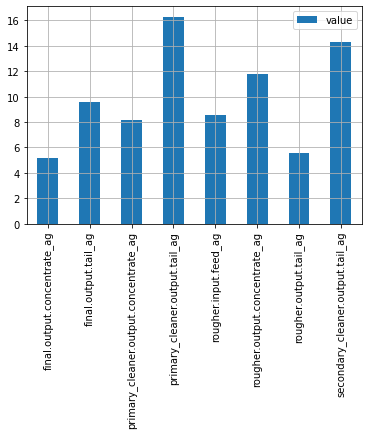

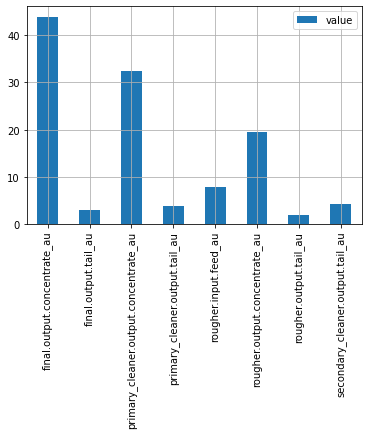

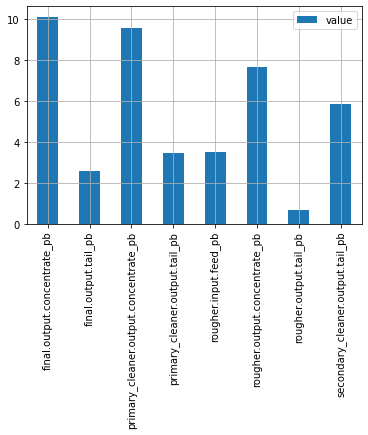

In [10]:
ag_ind=[]
ag_data=[]
au_ind=[]
au_data=[]
pb_ind=[]
pb_data=[]
for col in data_train:
    mean=0
    if 'ag' in col:
        mean = data_train[col].mean()
        ag_ind.append(col)
        ag_data.append(mean)
    if 'au' in col and 'floatbank' not in 'col' and 'sulfate' not in col and 'ratio' not in col:
        mean = data_train[col].mean()
        au_ind.append(col)
        au_data.append(mean)
    if 'pb' in col and 'ratio' not in col:
        mean = data_train[col].mean()
        pb_ind.append(col)
        pb_data.append(mean)    

columns = ['value']        
ag = pd.DataFrame(data=ag_data, index=ag_ind, columns=columns)
au = pd.DataFrame(data=au_data, index=au_ind, columns=columns)
pb = pd.DataFrame(data=pb_data, index=pb_ind, columns=columns)
ag.plot(kind='bar', grid=True)
au.plot(kind='bar', grid=True)
pb.plot(kind='bar', grid=True)
plt.show()

концентрация серебра (Ag) падает в процессе обогащения с почти 12 единиц после грубой очистки до 5 единиц после финальной очистки. В процессе очистки серебро в больших концентрациях обнаруживается в отвальных хвостах на первом (16 единиц), втором (14 единиц) и финальном (10 единиц) этапе обогащения.<br>
концентрация золота (Au) растет в процессе обогащения с 20 единиц после грубой очистки до 45 единиц после финальной очистки. Концентрация золота в отвальных хвостах на первичном и вторичном этапе переработки равны и составляет 4 единицы. После финальной очистки концентрация золота в отвальных хвостах составляет 2 единицы<br>
концентрация свинца (Pb) незначительно растет в процессе обогащения с 8 единиц после грубой очистки до 10 единиц после финальной очистки. В отвальных хвостах наивысшая концентрация после второй очистки - 6 единиц, после первичной очистки концентрация свинца в отвальных хвостах составляет 3,5 единицы, после финальной очистки 2,5 единицы.

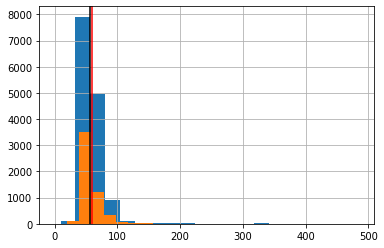

In [11]:
data_train['rougher.input.feed_size'].hist(bins=20)
data_test['rougher.input.feed_size'].hist(bins=20)
plt.axvline(data_train['rougher.input.feed_size'].mean(), color='red')
plt.axvline(data_test['rougher.input.feed_size'].mean(), color='black')

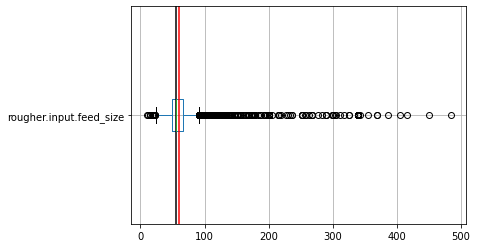

In [12]:
data_train.boxplot(column=['rougher.input.feed_size'], vert=False)
plt.axvline(data_train['rougher.input.feed_size'].mean(), color='red')
plt.axvline(data_test['rougher.input.feed_size'].mean(), color='black')

формы распределений размеров гранул сырья в обучающей и тестовой выборке имеют схожую форму. Выборки имеют длинный правый хвост. данные о размерах гранул сырья имеют выбросы.

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Вывод верный!</font>

In [13]:
data_train ['total_rougher.input.feed'] = (data_train['rougher.input.feed_ag']+
                                           data_train['rougher.input.feed_pb']+
                                           data_train['rougher.input.feed_au']+data_train['rougher.input.feed_sol'])

data_test ['total_rougher.input.feed'] = (data_test['rougher.input.feed_ag']+
                                          data_train['rougher.input.feed_pb']+
                                          data_train['rougher.input.feed_au']+data_train['rougher.input.feed_sol'])

data_train ['total_primary_cleaner.output.concentrate'] = (data_train['primary_cleaner.output.concentrate_ag']+
                                                           data_train['primary_cleaner.output.concentrate_pb']+
                                                           data_train['primary_cleaner.output.concentrate_au']+
                                                           data_train['primary_cleaner.output.concentrate_sol'])

data_train ['total_final.output.concentrate'] = (data_train['final.output.concentrate_ag']+
                                                 data_train['final.output.concentrate_pb']+
                                                 data_train['final.output.concentrate_au']+
                                                 data_train['final.output.concentrate_sol'])

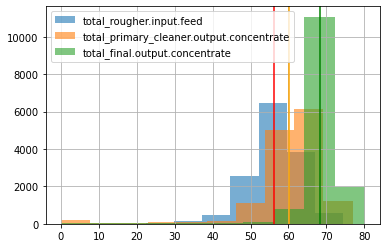

In [14]:
data_train ['total_rougher.input.feed'].hist(alpha=0.6, legend='rougher.input.feed')
data_train ['total_primary_cleaner.output.concentrate'].hist(alpha=0.6,
                                                        legend='total_primary_cleaner.output.concentrate')
data_train ['total_final.output.concentrate'].hist(alpha=0.6, legend='total_final.output.concentrate')
plt.axvline(data_train['total_rougher.input.feed'].mean(), color='red')
plt.axvline(data_train['total_primary_cleaner.output.concentrate'].mean(), color='orange')
plt.axvline(data_train['total_final.output.concentrate'].mean(), color='green')

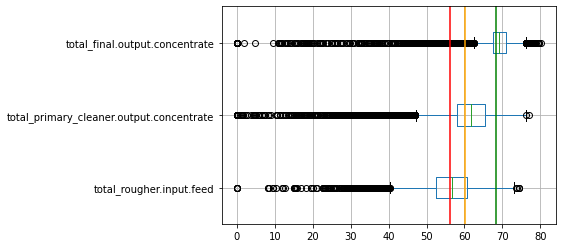

In [15]:
data_train.boxplot(column=['total_rougher.input.feed', 
                    'total_primary_cleaner.output.concentrate', 'total_final.output.concentrate'], 
                    vert=False, meanline=True)
plt.axvline(data_train['total_rougher.input.feed'].mean(), color='red')
plt.axvline(data_train['total_primary_cleaner.output.concentrate'].mean(), color='orange')
plt.axvline(data_train['total_final.output.concentrate'].mean(), color='green')

Суммарная концентрация веществ (Ag, Au, Pb) в процессе обогащения растет. Размах величин концентрации становится меньше в процессе обогащения (сокращение межквартильного расстояния). Однако в процессе обогащения появляется большое количество выбросов слева (1 квартиль суммарного количества финального выхода веществ совпадает со средним значением выборки - длинный левый хвост).

In [16]:
rougher_input_feed_threshold = (
                                    (data_train['total_rougher.input.feed'].quantile(0.25)-
                                    ((data_train['total_rougher.input.feed'].quantile(0.75) 
                                    - data_train['total_rougher.input.feed'].quantile(0.25))*1.5))
                                )
total_primary_cleaner_output_concentrate_threshold = (
                                    (data_train['total_primary_cleaner.output.concentrate'].quantile(0.25)-
                                    ((data_train['total_primary_cleaner.output.concentrate'].quantile(0.75) 
                                    - data_train['total_primary_cleaner.output.concentrate'].quantile(0.25))*1.5))
                                                        )
total_final_output_concentrate_threshold = (
                                    (data_train['total_final.output.concentrate'].quantile(0.25)-
                                    ((data_train['total_final.output.concentrate'].quantile(0.75) 
                                    - data_train['total_final.output.concentrate'].quantile(0.25))*1.5))
                                            )
rougher_input_feed_threshold_test = (
                                    (data_test['total_rougher.input.feed'].quantile(0.25)-
                                    ((data_test['total_rougher.input.feed'].quantile(0.75) 
                                    - data_test['total_rougher.input.feed'].quantile(0.25))*1.5))
                                    )
rougher_input_feed_size_threshold = (
                                    (data_train['rougher.input.feed_size'].quantile(0.25)-
                                    ((data_train['rougher.input.feed_size'].quantile(0.75) - 
                                    data_train['rougher.input.feed_size'].quantile(0.25))*1.5))
                                    )
rougher_input_feed_size_threshold_test = (
                                    (data_test['rougher.input.feed_size'].quantile(0.25)
                                    -((data_test['rougher.input.feed_size'].quantile(0.75)
                                    -data_test['rougher.input.feed_size'].quantile(0.25))*1.5))
                                        )

In [17]:
data_test = data_test[(data_test['rougher.input.feed_size']>rougher_input_feed_size_threshold_test) 
    & (data_test['total_rougher.input.feed']>rougher_input_feed_threshold_test)]

data_train = data_train[(data_train['rougher.input.feed_size']>=rougher_input_feed_size_threshold) 
    & (data_train['total_rougher.input.feed']>=rougher_input_feed_threshold) 
    & (data_train['total_primary_cleaner.output.concentrate']>=total_primary_cleaner_output_concentrate_threshold) 
    & (data_train['total_final.output.concentrate']>=total_final_output_concentrate_threshold)]

In [18]:
data_test['primary_cleaner.state.floatbank_air'] =  (data_test.loc[:, ["primary_cleaner.state.floatbank8_a_air",
                                                                    "primary_cleaner.state.floatbank8_b_air",
                                                                    "primary_cleaner.state.floatbank8_c_air",
                                                                    "primary_cleaner.state.floatbank8_c_air"]]).mean(axis=1)
data_test['primary_cleaner.state.floatbank_level'] = (data_test.loc[:, ['primary_cleaner.state.floatbank8_a_level',
                                                    'primary_cleaner.state.floatbank8_b_level',
                                                    'primary_cleaner.state.floatbank8_c_level',
                                                    'primary_cleaner.state.floatbank8_d_level']]).mean(axis=1)
data_test['rougher.input.floatbank_sulfate'] = (data_test.loc[:,['rougher.input.floatbank10_sulfate', 
                                                'rougher.input.floatbank11_sulfate']]).mean(axis=1)
data_test['rougher.input.floatbank_xanthate'] = (data_test.loc[:,['rougher.input.floatbank10_xanthate', 
                                                'rougher.input.floatbank11_xanthate']]).mean(axis=1)
data_test['rougher.state.floatbank_air'] = (data_test.loc[:,['rougher.state.floatbank10_a_air',
                                            'rougher.state.floatbank10_b_air',
                                            'rougher.state.floatbank10_c_air',
                                            'rougher.state.floatbank10_d_air',
                                            'rougher.state.floatbank10_e_air',               
                                            'rougher.state.floatbank10_f_air']]).mean(axis=1)
data_test['rougher.state.floatbank_level'] = (data_test.loc[:,['rougher.state.floatbank10_a_level',
                                            'rougher.state.floatbank10_b_level',
                                            'rougher.state.floatbank10_c_level',
                                            'rougher.state.floatbank10_d_level',
                                            'rougher.state.floatbank10_e_level',                  
                                            'rougher.state.floatbank10_f_level']]).mean(axis=1)
data_test['secondary_cleaner.state.floatbank_air'] = (data_test.loc[:,['secondary_cleaner.state.floatbank2_a_air',
                                                     'secondary_cleaner.state.floatbank2_b_air',
                                                     'secondary_cleaner.state.floatbank3_a_air',
                                                     'secondary_cleaner.state.floatbank3_b_air',
                                                     'secondary_cleaner.state.floatbank4_a_air',
                                                     'secondary_cleaner.state.floatbank4_b_air',
                                                     'secondary_cleaner.state.floatbank5_a_air',
                                                     'secondary_cleaner.state.floatbank5_b_air',
                                                     'secondary_cleaner.state.floatbank6_a_air']]).mean(axis=1)
data_test['secondary_cleaner.state.floatbank_level'] = (data_test.loc[:,['secondary_cleaner.state.floatbank2_a_level',
                                                     'secondary_cleaner.state.floatbank2_b_level',
                                                     'secondary_cleaner.state.floatbank3_a_level',
                                                     'secondary_cleaner.state.floatbank3_b_level',
                                                     'secondary_cleaner.state.floatbank4_a_level',
                                                     'secondary_cleaner.state.floatbank4_b_level',
                                                     'secondary_cleaner.state.floatbank5_a_level',
                                                     'secondary_cleaner.state.floatbank5_b_level',
                                                     'secondary_cleaner.state.floatbank6_a_level']]).mean(axis=1)
data_test.drop(
    ['rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
    'primary_cleaner.state.floatbank8_a_air',
    'primary_cleaner.state.floatbank8_b_air',
    'primary_cleaner.state.floatbank8_c_air',
    'primary_cleaner.state.floatbank8_d_air',
    'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_b_level',
    'primary_cleaner.state.floatbank8_c_level',
    'primary_cleaner.state.floatbank8_d_level',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank11_sulfate',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_e_air', 
    'rougher.state.floatbank10_f_air', 
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_level',
    'secondary_cleaner.state.floatbank2_a_air',
    'secondary_cleaner.state.floatbank2_b_air',
    'secondary_cleaner.state.floatbank3_a_air',
    'secondary_cleaner.state.floatbank3_b_air',
    'secondary_cleaner.state.floatbank4_a_air',
    'secondary_cleaner.state.floatbank4_b_air',
    'secondary_cleaner.state.floatbank5_a_air',
    'secondary_cleaner.state.floatbank5_b_air',
    'secondary_cleaner.state.floatbank6_a_air',
    'secondary_cleaner.state.floatbank2_a_level',
    'secondary_cleaner.state.floatbank2_b_level',
    'secondary_cleaner.state.floatbank3_a_level',
    'secondary_cleaner.state.floatbank3_b_level',
    'secondary_cleaner.state.floatbank4_a_level',
    'secondary_cleaner.state.floatbank4_b_level',
    'secondary_cleaner.state.floatbank5_a_level',
    'secondary_cleaner.state.floatbank5_b_level',
    'secondary_cleaner.state.floatbank6_a_level' 
    ], axis = 1, inplace=True)

In [19]:
data_train['primary_cleaner.state.floatbank_air'] =  (data_train.loc[:, ["primary_cleaner.state.floatbank8_a_air",
                                                                        "primary_cleaner.state.floatbank8_b_air",
                                                                        "primary_cleaner.state.floatbank8_c_air",
                                                                        "primary_cleaner.state.floatbank8_c_air"]]).mean(axis=1)
data_train['primary_cleaner.state.floatbank_level'] = (data_train.loc[:, ['primary_cleaner.state.floatbank8_a_level',
                                                    'primary_cleaner.state.floatbank8_b_level',
                                                    'primary_cleaner.state.floatbank8_c_level',
                                                    'primary_cleaner.state.floatbank8_d_level']]).mean(axis=1)
data_train['rougher.input.floatbank_sulfate'] = (data_train.loc[:,['rougher.input.floatbank10_sulfate', 
                                                'rougher.input.floatbank11_sulfate']]).mean(axis=1)
data_train['rougher.input.floatbank_xanthate'] = (data_train.loc[:,['rougher.input.floatbank10_xanthate', 
                                                'rougher.input.floatbank11_xanthate']]).mean(axis=1)
data_train['rougher.state.floatbank_air'] = (data_train.loc[:,['rougher.state.floatbank10_a_air',
                                            'rougher.state.floatbank10_b_air',
                                            'rougher.state.floatbank10_c_air',
                                            'rougher.state.floatbank10_d_air',
                                            'rougher.state.floatbank10_e_air',               
                                            'rougher.state.floatbank10_f_air']]).mean(axis=1)
data_train['rougher.state.floatbank_level'] = (data_train.loc[:,['rougher.state.floatbank10_a_level',
                                            'rougher.state.floatbank10_b_level',
                                            'rougher.state.floatbank10_c_level',
                                            'rougher.state.floatbank10_d_level',
                                            'rougher.state.floatbank10_e_level',                  
                                            'rougher.state.floatbank10_f_level']]).mean(axis=1)
data_train['secondary_cleaner.state.floatbank_air'] = (data_train.loc[:,['secondary_cleaner.state.floatbank2_a_air',
                                                     'secondary_cleaner.state.floatbank2_b_air',
                                                     'secondary_cleaner.state.floatbank3_a_air',
                                                     'secondary_cleaner.state.floatbank3_b_air',
                                                     'secondary_cleaner.state.floatbank4_a_air',
                                                     'secondary_cleaner.state.floatbank4_b_air',
                                                     'secondary_cleaner.state.floatbank5_a_air',
                                                     'secondary_cleaner.state.floatbank5_b_air',
                                                     'secondary_cleaner.state.floatbank6_a_air']]).mean(axis=1)
data_train['secondary_cleaner.state.floatbank_level'] = (data_train.loc[:,['secondary_cleaner.state.floatbank2_a_level',
                                                     'secondary_cleaner.state.floatbank2_b_level',
                                                     'secondary_cleaner.state.floatbank3_a_level',
                                                     'secondary_cleaner.state.floatbank3_b_level',
                                                     'secondary_cleaner.state.floatbank4_a_level',
                                                     'secondary_cleaner.state.floatbank4_b_level',
                                                     'secondary_cleaner.state.floatbank5_a_level',
                                                     'secondary_cleaner.state.floatbank5_b_level',
                                                     'secondary_cleaner.state.floatbank6_a_level']]).mean(axis=1)
data_train.drop(
    ['rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
    'primary_cleaner.state.floatbank8_a_air',
    'primary_cleaner.state.floatbank8_b_air',
    'primary_cleaner.state.floatbank8_c_air',
    'primary_cleaner.state.floatbank8_d_air',
    'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_b_level',
    'primary_cleaner.state.floatbank8_c_level',
    'primary_cleaner.state.floatbank8_d_level',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank11_sulfate',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_e_air', 
    'rougher.state.floatbank10_f_air', 
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_level', 
    'secondary_cleaner.state.floatbank2_a_air',
    'secondary_cleaner.state.floatbank2_b_air',
    'secondary_cleaner.state.floatbank3_a_air',
    'secondary_cleaner.state.floatbank3_b_air',
    'secondary_cleaner.state.floatbank4_a_air',
    'secondary_cleaner.state.floatbank4_b_air',
    'secondary_cleaner.state.floatbank5_a_air',
    'secondary_cleaner.state.floatbank5_b_air',
    'secondary_cleaner.state.floatbank6_a_air',
    'secondary_cleaner.state.floatbank2_a_level',
    'secondary_cleaner.state.floatbank2_b_level',
    'secondary_cleaner.state.floatbank3_a_level',
    'secondary_cleaner.state.floatbank3_b_level',
    'secondary_cleaner.state.floatbank4_a_level',
    'secondary_cleaner.state.floatbank4_b_level',
    'secondary_cleaner.state.floatbank5_a_level',
    'secondary_cleaner.state.floatbank5_b_level',
    'secondary_cleaner.state.floatbank6_a_level' 
    ], axis = 1, inplace=True)

In [ ]:
scaler = RobustScaler()

In [20]:
tab_to_merge = data_full[['date','final.output.recovery', 'rougher.output.recovery']]
data_test_1 = data_test.merge(tab_to_merge, on='date', how='left')

target_test_final=data_test_1['final.output.recovery']
target_test_rougher=data_test_1['rougher.output.recovery']
target_train_final = data_train['final.output.recovery']
target_train_rougher = data_train['rougher.output.recovery']
target_full_final = data_full['final.output.recovery']
target_full_rougher = data_full['rougher.output.recovery']

features_test_final = data_test.loc[:, ~data_test.columns.str.contains(r"date") & 
                                     ~data_test.columns.str.contains(r"total")]



features_test_rougher = data_test.loc[:, data_test.columns.str.contains(r"rougher")& 
                                       ~data_test.columns.str.contains(r"total")]

features_train_rougher = data_train.loc[:, data_train.columns.str.contains(r"rougher") & 
                                        ~data_train.columns.str.contains(r"output") 
                                        & ~data_train.columns.str.contains(r"calculation") & 
                                        ~data_train.columns.str.contains(r"recovery") 
                                        & ~data_train.columns.str.contains(r"total")]


features_train_final = data_train.loc[:, ~data_train.columns.str.contains(r"output") 
                                        & ~data_train.columns.str.contains(r"calculation") & 
                                      ~data_train.columns.str.contains(r"recovery") 
                                        & ~data_train.columns.str.contains(r"total") & 
                                      ~data_train.columns.str.contains(r"date")]


features_full_rougher = data_full.loc[:, data_full.columns.str.contains(r"rougher") & 
                                      ~data_full.columns.str.contains(r"output") & 
                                      ~data_full.columns.str.contains(r"calculation") & 
                                      ~data_full.columns.str.contains(r"recovery")]


features_full_final = data_full.loc[:, ~data_full.columns.str.contains(r"output") & 
                                    ~data_full.columns.str.contains(r"calculation") & 
                                    ~data_full.columns.str.contains(r"recovery") & 
                                    ~data_full.columns.str.contains(r"date")]


features_full_final, features_full_final_valid, target_full_final, target_full_final_valid = (
             train_test_split(features_full_final, target_full_final, test_size = 0.2, random_state=12345))

features_full_rougher, features_full_rougher_valid, target_full_rougher, target_full_rougher_valid = (
            train_test_split(features_full_rougher, target_full_rougher, test_size = 0.2, random_state=12345))

In [21]:
features_test_rougher

,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_au,rougher.input.floatbank_sulfate,rougher.input.floatbank_xanthate,rougher.state.floatbank_air,rougher.state.floatbank_level
0,489.793655,62.710452,12.084103,16.895197,6.152094,1108.110791,-391.000981
1,490.104534,61.961163,11.918977,16.999298,6.000679,1107.884879,-392.537336
2,489.617969,66.903807,12.091332,16.987308,5.852113,1107.363449,-392.002366
3,476.618130,59.865919,12.181597,16.523710,5.802796,1109.026279,-391.053037
4,488.248117,63.315324,11.290425,13.628655,5.738858,1144.139906,-391.377914
...,...,...,...,...,...,...,...
5285,521.685155,66.758479,10.554544,10.109993,7.201053,992.789444,-466.368166
5286,530.195798,62.560684,10.254051,9.979175,7.201426,996.245811,-464.406098
5287,546.306868,73.647513,10.169094,10.183840,7.197466,991.711002,-466.240373
5288,547.331405,78.066446,10.071156,10.728632,7.200446,991.941539,-466.829908


In [22]:
features_train_final

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_au,primary_cleaner.state.floatbank_air,primary_cleaner.state.floatbank_level,rougher.input.floatbank_sulfate,rougher.input.floatbank_xanthate,rougher.state.floatbank_air,rougher.state.floatbank_level,secondary_cleaner.state.floatbank_air,secondary_cleaner.state.floatbank_level
0,127.092003,10.128295,7.25,0.988759,523.546326,55.486599,6.486150,1550.239441,-501.852577,11.911680,6.006904,1437.476257,-439.947205,17.102487,-511.818186
1,125.629232,10.296251,7.25,1.002663,525.290581,57.278666,6.478583,1576.026419,-499.754407,11.983678,6.009180,1433.499125,-441.798629,17.087944,-511.918731
2,123.819808,11.316280,7.25,0.991265,530.026610,57.510649,6.362222,1601.487483,-500.325767,11.920454,6.201005,1433.012774,-441.742662,17.311601,-511.661580
3,122.270188,11.322140,7.25,0.996739,542.590390,57.792734,6.118189,1600.309061,-500.352361,11.661272,6.199877,1433.131689,-441.780288,17.312067,-511.164860
4,117.988169,11.913613,7.25,1.009869,540.531893,56.047189,5.663707,1600.485337,-500.194966,10.959138,6.196861,1433.787571,-441.430137,17.302416,-511.708756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,123.381787,8.028927,6.50,1.304232,560.889077,85.718304,5.335862,1648.579915,-399.943668,7.764757,9.157339,1007.180234,-465.643987,23.110396,-500.126762
14145,120.878188,7.962636,6.50,1.302419,559.031805,119.499241,4.838619,1649.122521,-400.371084,7.226097,9.301438,1006.852024,-466.364674,23.098611,-500.389100
14146,105.666118,7.955111,6.50,1.315926,555.682872,122.262690,4.525061,1648.539416,-399.846595,6.585075,9.299870,1009.431386,-468.543095,23.101292,-512.922114
14147,98.880538,7.984164,6.50,1.241969,544.731687,123.742430,4.362781,1648.148694,-399.656755,6.209818,9.297452,1009.512650,-465.868534,23.104930,-509.435196


Рассчитаны границы для выбраковки аномально низких значений размера гранул сырья, суммарной концентрации металлов во входяшем сырье, суммарной концентрации металлов после первичной очистки, суммарной концентрации металлов после финальной обработки.

Вывод. 1.Исследованы концентрации отдельных веществ по этапа обогащения. Концентрация золота в процессе обогащения растет, концентрация серебра в процессе обогащения падает, концентрация свинца растет в процессе обогащения незначительно.<br>
2.Формы распределений гранул сырья в обучающей и тестовой выборках совпадают.<br>
3.Суммарная концентрация веществ в процессе обогащения растет, межквартильный размах сокращается со смещением среднего по выборке влево (большое количество выбросов слева - левый хвост) в наличии есть даже значения около нуля.<br>
4.Данные очищены от выбросов по размеру гранул сырья (удалены данные с аномально мелкими гранулами), суммарной концентрации металлов во входяшем сырье, суммарной концентрации металлов после первичной очистки, суммарной концентрации металлов после финальной обработки. <br>
5.Данные приготовлены для последующего построения моделей машинного обучения.

## Модель

In [23]:
def sMAPE_final(target_rougher, predict_rougher, target_final, predict_final):
    rougher_sMAPE = (((abs(target_rougher-predict_rougher))/((abs(target_rougher)+abs(predict_rougher))/2)).mean())*100
    final_sMAPE = (((abs(target_final-predict_final))/((abs(target_final)+abs(predict_final))/2)).mean())*100
    total_sMAPE = rougher_sMAPE*0.25+final_sMAPE*0.75
    return total_sMAPE

In [24]:
def sMAPE_for_model_selection (target, predict):
    sMAPE_for_model_selection = (((abs(target-predict))/((abs(target)+abs(predict))/2)).mean())*100
    return sMAPE_for_model_selection

### Случайный лес

In [25]:
best_model_rf=None
best_sMAPE=1000000
best_depth = 0
best_est = 0
for n_estimators in range (30, 100, 10):
    for max_depth in range (10, 16, 1):
        model = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, random_state=12345)
        model.fit(features_train_rougher, target_train_rougher)
        score = make_scorer(sMAPE_for_model_selection, greater_is_better=True)
        cv_result = cross_validate(model, features_train_rougher, target_train_rougher, scoring=score, cv=2)
        sMAPE = abs(cv_result['test_score']).mean()
        if sMAPE<best_sMAPE:
            best_sMAPE=sMAPE
            best_model_rf = model
            best_depth = max_depth
            best_est = n_estimators


print(('Параметры случайного леса: Глубина дерева {}, количество деревьев {}, sMAPE {:.2f}'
      .format (best_depth, best_est, best_sMAPE)))

Параметры случайного леса: Глубина дерева 10, количество деревьев 80, sMAPE 16.42


In [26]:
score = make_scorer(sMAPE_for_model_selection, greater_is_better=True)
cv_result = cross_validate(best_model_rf, features_train_final, target_train_final, scoring=score, cv=5)
print('sMAPE на финального обогащения случайный лес {:.2f}'.format (abs(cv_result['test_score'].mean())))

sMAPE на финального обогащения случайный лес 9.04


#### Предварительное обогащение

In [27]:
predict_rougher = best_model_rf.predict(features_test_rougher)

In [28]:
sMAPE = sMAPE_for_model_selection (target_test_final, predict_rougher)
print('sMAPE на тестовой выборке для предварительного обогащения {:.2f}'.format(sMAPE))

sMAPE на тестовой выборке для предварительного обогащения 22.36


#### Финальное обогащение

In [29]:
best_model_rf.fit(features_test_final, target_test_final)

RandomForestRegressor(max_depth=10, n_estimators=80, random_state=12345)

In [30]:
predict_final = best_model_rf.predict(features_test_final)

In [31]:
sMAPE = sMAPE_for_model_selection (target_test_final, predict_final)
print('sMAPE на тестовой выборке для финального обогащения {:.2f}'.format(sMAPE))

sMAPE на тестовой выборке для финального обогащения 6.89


### Линейная регрессия

In [32]:
lr=LinearRegression(n_jobs=-1)
lr.fit(features_train_rougher, target_train_rougher)

LinearRegression(n_jobs=-1)

In [33]:
score = make_scorer(sMAPE_for_model_selection, greater_is_better=True)
cv_result = cross_validate(lr, features_train_rougher, target_train_rougher, scoring=score, cv=5)
print('sMAPE на предварительного обогащения линейная регрессия {:.2f}'.format(abs(cv_result['test_score'].mean())))

sMAPE на предварительного обогащения линейная регрессия 12.81


In [34]:
score = make_scorer(sMAPE_for_model_selection, greater_is_better=True)
cv_result = cross_validate(lr, features_train_final, target_train_final, scoring=score, cv=5)
print('sMAPE на финального обогащения линейная регрессия {:.2f}'.format (abs(cv_result['test_score'].mean())))

sMAPE на финального обогащения линейная регрессия 8.07


#### Предварительное обогащение

In [37]:
predict_rougher_lr = lr.predict(features_test_rougher)

In [38]:
sMAPE = sMAPE_for_model_selection (target_test_rougher, predict_rougher_lr)
print('sMAPE на тестовой выборке для предварительного обогащения {:.2f}'.format(sMAPE))

sMAPE на тестовой выборке для предварительного обогащения 9.03


#### Финальное обогащение

In [39]:
lr.fit(features_train_final,target_train_final)
predict_final_lr = lr.predict(features_test_final)

In [41]:
sMAPE = sMAPE_for_model_selection (target_test_final, predict_final_lr)
print('sMAPE на тестовой выборке для финального обогащения {:.2f}'.format(sMAPE))

sMAPE на тестовой выборке для финального обогащения 9.36


### Градиентный бустинг

In [42]:
gb = GradientBoostingRegressor(random_state=12345)
gb.fit(features_train_rougher, target_train_rougher)
predict_rougher_gb = gb.predict(features_test_rougher)

In [43]:
score = make_scorer(sMAPE_for_model_selection, greater_is_better=True)
cv_result = cross_validate(gb, features_train_rougher, target_train_rougher, scoring=score, cv=5)
print('sMAPE на предварительного обогащения градиентный бустинг {:.2f}'.format(abs(cv_result['test_score'].mean())))

sMAPE на предварительного обогащения градиентный бустинг 14.26


In [44]:
score = make_scorer(sMAPE_for_model_selection, greater_is_better=True)
cv_result = cross_validate(gb, features_train_final, target_train_final, scoring=score, cv=5)
print('sMAPE на финального обогащения градиентный бустинг {:.2f}'.format (abs(cv_result['test_score'].mean())))

sMAPE на финального обогащения градиентный бустинг 8.60


#### Предварительное обогащение

In [45]:
sMAPE = sMAPE_for_model_selection (target_test_rougher, predict_rougher_gb)
print('sMAPE на тестовой выборке для предварительного обогащения {:.2f}'.format(sMAPE))

sMAPE на тестовой выборке для предварительного обогащения 8.43


#### Финальное обогащение

In [46]:
gb.fit(features_train_final, target_train_final)

GradientBoostingRegressor(random_state=12345)

In [47]:
predict_test_final_gb = gb.predict(features_test_final)

In [48]:
sMAPE = sMAPE_for_model_selection (target_test_rougher, predict_test_final_gb)
print('sMAPE на тестовой выборке для предварительного обогащения {:.2f}'.format(sMAPE))

sMAPE на тестовой выборке для предварительного обогащения 27.98


### sMAPE

In [49]:
final_sMAPE = sMAPE_final(target_test_rougher, predict_rougher_gb, target_test_final, predict_test_final_gb)
final_sMAPE_lr = sMAPE_final(target_test_rougher, predict_rougher_lr, target_test_final, predict_final_lr)
final_sMAPE_rf = sMAPE_final(target_test_rougher, predict_rougher, target_test_final, predict_final)

In [50]:
print('sMAPE предсказанных коэффициентов предварительного и финального обогащения градиентный бустинг {:.2f}'. format(final_sMAPE))
print('sMAPE предсказанных коэффициентов предварительного и финального обогащения линейная регрессия {:.2f}'. format(final_sMAPE_lr))
print('sMAPE предсказанных коэффициентов предварительного и финального обогащения случайный лес {:.2f}'. format(final_sMAPE_rf))

sMAPE предсказанных коэффициентов предварительного и финального обогащения градиентный бустинг 9.14
sMAPE предсказанных коэффициентов предварительного и финального обогащения линейная регрессия 9.28
sMAPE предсказанных коэффициентов предварительного и финального обогащения случайный лес 7.61


Валидация sMAPE на константной модели регрессии

In [51]:
score = make_scorer(sMAPE_for_model_selection, greater_is_better=False)
dr = DummyRegressor(strategy='mean')
dr.fit(features_train_rougher, target_train_rougher)
predict_rougher_dr = dr.predict(features_test_rougher)
dr.fit(features_train_final, target_train_final)
predict_full_dr = dr.predict(features_test_final)

In [52]:
final_sMAPE = sMAPE_final(target_test_rougher, predict_rougher_dr, target_test_final, predict_full_dr)
print('sMAPE константной модели предсказания коэффициентов предварительного и финального обогащения {:.2f}'
     . format(final_sMAPE))

sMAPE константной модели предсказания коэффициентов предварительного и финального обогащения 9.93


Для расчета sMAPE возьмем данные из предсказаний случайного леса. sMAPE равно 7.61 %. sMAPE констатной модели равно 9,93 %.

Выводы по проекту:<br>
1.Получены данные (обучающие, тестовые, полные) о технологическом процессе по обогащению золота. Данные имеют пропуски, которые заполнены средними значениями соответствующего столбца. Проверена корректность расчета табличного показателя обогащения.<br>
2.Проанализированы данные о изменении концентрации металлов в процессе обогащения золота. Концентрация золота растет, концентрация серебра падает (растет концентрация серебра в отвалах), концентрация свинца растет незначительно.<br>
3.Размеры гранул сырья распределены пожожим образом в обучающей и тестовой выборках. Данные имет выбросы справа и слева. Расчитаны суммарные концентрации металлов по этапам обогащения. Данные о суммарной концентрации металлов имеют выбросы, преимущественно слева. Уберем левые выборосы указанных данных из обучающей и тестовой выборок. Сформируем набор признаков для моделей машинного обучения.<br>
4.Взяты модели случайного леса, линейной регрессии и градиентного бустинга для предсказаний коэффициента обогащения золота после входной обработки и после финальной обработки. Проведена кросс-валидация моделей. Для предсказаний выбрана модель линейной регрессии как имеющая наименьшую RMSE. На основании предсказаний модели линейной регрессии расчитан показатель sMAPE он равен 7,61 %.